# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

#### **Zajistíme vše potřebné...**

In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

rd_seed = 333 # konstanta pro random operace
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

In [94]:
# Načtení dat z .csv souborů
data = pd.read_csv("data.csv")
evaluation = pd.read_csv("evaluation.csv")

In [95]:
# Základní přehled
display(data.head())
display(data.info())
print("\nNumber of missing items in each column...")
display(data.isnull().sum(axis=0))
print("\nNumber of unique values...")
display(data.nunique())

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None


Number of missing items in each column...


ID             0
survived       0
pclass         0
name           0
sex            0
age          198
sibsp          0
parch          0
ticket         0
fare           1
cabin        767
embarked       2
home.dest    434
dtype: int64


Number of unique values...


ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

## Příprava dat

* Dále budeme **současně** upravovat dva datasety, abychom na ně mohli použít naše modely

* Sloupec "ID" lze použít jako identifikátor konkrétního cestujícího

In [96]:
data = data.set_index("ID", drop=True, verify_integrity=True)
evaluation = evaluation.set_index("ID", drop=True, verify_integrity=True)

In [97]:
data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,,
0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


* Příznak "pclass" je **ordinílní**, dá se ho seřadit podle komfortu třidy

In [98]:
pclass_unique = data.pclass.unique()
print(pclass_unique)

[3 2 1]


* Konverze příznaku "pclass" na categoricky typ

In [99]:
pclass_category = pd.api.types.CategoricalDtype(categories=pclass_unique, ordered=True)

data.pclass = data.pclass.astype(pclass_category)
evaluation.pclass = evaluation.pclass.astype(pclass_category)

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   survived   1000 non-null   int64   
 1   pclass     1000 non-null   category
 2   name       1000 non-null   object  
 3   sex        1000 non-null   object  
 4   age        802 non-null    float64 
 5   sibsp      1000 non-null   int64   
 6   parch      1000 non-null   int64   
 7   ticket     1000 non-null   object  
 8   fare       999 non-null    float64 
 9   cabin      233 non-null    object  
 10  embarked   998 non-null    object  
 11  home.dest  566 non-null    object  
dtypes: category(1), float64(2), int64(3), object(6)
memory usage: 94.9+ KB


In [101]:
print(f'Number of unique names: {data.name.nunique()}')

Number of unique names: 999


 * Je zřejmé, že naše prognóza nebude záviset na jménu
 * V případě rozhodujícího stromu nebude možné nějak adekvátně rozdělit cestujících
  * V případě metody kNN nebude možné najít cestujícího se stejným jménem
* Proto můžeme tento atribut odstranit

In [102]:
data = data.drop(columns=["name"])
evaluation = evaluation.drop(columns=["name"])

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   survived   1000 non-null   int64   
 1   pclass     1000 non-null   category
 2   sex        1000 non-null   object  
 3   age        802 non-null    float64 
 4   sibsp      1000 non-null   int64   
 5   parch      1000 non-null   int64   
 6   ticket     1000 non-null   object  
 7   fare       999 non-null    float64 
 8   cabin      233 non-null    object  
 9   embarked   998 non-null    object  
 10  home.dest  566 non-null    object  
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 87.0+ KB


* Rozdělíme atribut "home.dest" na dva atributy "home" a "dest"

In [104]:
data[["home", "dest"]] = data["home.dest"].str.rsplit(',', n=1, expand=True)
evaluation[["home", "dest"]] = evaluation["home.dest"].str.rsplit(',', n=1, expand=True)

In [105]:
data.drop(columns="home.dest", inplace=True)
evaluation.drop(columns="home.dest", inplace=True)

* Ostatní atributy jsou **nominální**, protože je nelze přirozeně sečadit

In [106]:
object_columns = data.select_dtypes(["object"]).columns
print("Nominal attributes...")
print(object_columns)

Nominal attributes...
Index(['sex', 'ticket', 'cabin', 'embarked', 'home', 'dest'], dtype='object')


* Dalším krokem je převést všechny zbývající atributy typu "object" na typ "category" a přiřadit jim číselné hodnoty
* Aby však ve dvou datasetech měly stejné hodnoty stejné číselné kódy, je třeba nejprve sloučit dva datasety do jednoho
* To však musí být provedeno se zachováním předchozí indexace, aby následně bylo možné bez ztráty dat rozdělit velký dataset na předchozí
* Spojit dva datasety stojí především proto, že funkce **cat.codes** přiřazuje čísla hodnotám v pořadí, ve kterém se tyto hodnoty objevují v datasetu

In [107]:
all_data = pd.concat([data, evaluation], ignore_index=False)

In [108]:
display(all_data.head())
display(all_data.tail())
all_data.info()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home,dest
ID,,,,,,,,,,,,
0,0.0,3,male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls",NY
1,0.0,3,male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN,NaN
2,0.0,3,male,4.0,3,2,347088,27.9000,NaN,S,NaN,NaN
3,1.0,3,female,NaN,1,0,370365,15.5000,NaN,Q,NaN,NaN
4,1.0,3,female,18.0,0,0,2657,7.2292,NaN,C,Greensburg,PA


,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home,dest
ID,,,,,,,,,,,,
1304,NaN,2,male,25.0,0,0,234686,13.0000,NaN,S,Southsea,Hants
1305,NaN,3,male,34.5,0,0,2683,6.4375,NaN,C,NaN,NaN
1306,NaN,3,male,NaN,0,0,368573,7.7500,NaN,Q,Ireland New York,NY
1307,NaN,1,male,24.0,0,0,PC 17593,79.2000,B86,C,NaN,NaN
1308,NaN,3,male,17.0,1,0,350048,7.0542,NaN,S,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  1000 non-null   float64 
 1   pclass    1309 non-null   category
 2   sex       1309 non-null   object  
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   int64   
 5   parch     1309 non-null   int64   
 6   ticket    1309 non-null   object  
 7   fare      1308 non-null   float64 
 8   cabin     295 non-null    object  
 9   embarked  1307 non-null   object  
 10  home      745 non-null    object  
 11  dest      681 non-null    object  
dtypes: category(1), float64(3), int64(2), object(6)
memory usage: 124.1+ KB


In [109]:
all_data[object_columns] = all_data[object_columns].astype('category').apply(lambda x: x.cat.codes)

* Zpět rozdělíme dataset na původní dva

In [110]:
data = all_data.iloc[:1000, :]
evaluation = all_data.iloc[1000:, :]

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  1000 non-null   float64 
 1   pclass    1000 non-null   category
 2   sex       1000 non-null   int8    
 3   age       802 non-null    float64 
 4   sibsp     1000 non-null   int64   
 5   parch     1000 non-null   int64   
 6   ticket    1000 non-null   int16   
 7   fare      999 non-null    float64 
 8   cabin     1000 non-null   int16   
 9   embarked  1000 non-null   int8    
 10  home      1000 non-null   int16   
 11  dest      1000 non-null   int8    
dtypes: category(1), float64(3), int16(3), int64(2), int8(3)
memory usage: 56.8 KB


In [112]:
columns_to_drop = ["survived"]
evaluation.drop(columns=columns_to_drop, inplace=True)
evaluation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1000 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    309 non-null    category
 1   sex       309 non-null    int8    
 2   age       244 non-null    float64 
 3   sibsp     309 non-null    int64   
 4   parch     309 non-null    int64   
 5   ticket    309 non-null    int16   
 6   fare      309 non-null    float64 
 7   cabin     309 non-null    int16   
 8   embarked  309 non-null    int8    
 9   home      309 non-null    int16   
 10  dest      309 non-null    int8    
dtypes: category(1), float64(2), int16(3), int64(2), int8(3)
memory usage: 15.2 KB


/tmp/ipykernel_6242/247838800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation.drop(columns=columns_to_drop, inplace=True)


* Funkce **cat.codes** přeložila chybějící hodnoty na -1, takže přeložíme všechny zbývající chybějící hodnoty v datasetu na hodnotu -1

In [113]:
data.isnull().sum(axis=0)

survived      0
pclass        0
sex           0
age         198
sibsp         0
parch         0
ticket        0
fare          1
cabin         0
embarked      0
home          0
dest          0
dtype: int64

In [114]:
data = data.replace(np.nan, -1)
evaluation = evaluation.replace(np.nan, -1)

In [115]:
data.isnull().sum(axis=0)

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
cabin       0
embarked    0
home        0
dest        0
dtype: int64

* Abychom se vyhnuli možným chybám, uděláme dvě kopie dat pro trénink zvlášť pro každý model

In [116]:
# Copy for decision tree data
tree_Xdata = data.drop(columns="survived")
tree_ydata = data.survived

# Copy for kNN
kNN_Xdata = data.drop(columns="survived")
kNN_ydata = data.survived

## Decision tree...
* Výhody tohoto modelu
    * Interpretovatelnost: snadno pochopitelná logika řešení.
    * Zvýraznění důležitých atributů: identifikují klíčové faktory přežití.
    * Snadné vnímání: prezentováno jako jednoduchá pravidla.
    * Zpracování různých typů dat: pracují s číselnými a kategorickými daty.

* Data rozdělíme do tří částí: trénovací, validační a testovací v poměru 60/20/20 %
* Používáme funkci **train_test_split()**

In [117]:
XtrainDT, XtestDT, ytrainDT, ytestDT = train_test_split(tree_Xdata, tree_ydata, test_size=0.4, random_state=rd_seed)

In [118]:
display(XtrainDT.shape)
display(ytrainDT.shape)
display(XtestDT.shape)
display(ytestDT.shape)

(600, 11)

(600,)

(400, 11)

(400,)

In [119]:
XvalDT, XtestDT, yvalDT, ytestDT = train_test_split(XtestDT, ytestDT, test_size=0.5, random_state=rd_seed)

In [120]:
display(XvalDT.shape)
display(yvalDT.shape)
display(XtestDT.shape)
display(ytestDT.shape)

(200, 11)

(200,)

(200, 11)

(200,)

* Vybereme hyperparametry, jejichž různé kombinace budeme testovat na našich datech

In [121]:
clf = DecisionTreeClassifier()
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

* Vybereme 3 hyperparametry
    * max_depth
    * criterion 
    * min_samples_split
* Pomocí funkce **ParameterGrid()** dostaneme všechny možné kombinace těchto hyperparametrů
* Pak každou kombinaci vyzkoušíme na validační množině, abychom našli tu "nejlepší"

In [122]:
param_grid = {
    'max_depth' : range(1,31),
    'criterion' : ['entropy', 'gini'],
    'min_samples_split' : range(2, 100, 5)
}
param_comb = ParameterGrid(param_grid)
print("Number of combination:", len(param_comb))
print("\nThe first 10 combinations...")
for i in range(10):
    print(param_comb[i])

Number of combination: 1200

The first 10 combinations...
{'min_samples_split': 2, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 7, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 12, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 17, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 22, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 27, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 32, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 37, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 42, 'max_depth': 1, 'criterion': 'entropy'}
{'min_samples_split': 47, 'max_depth': 1, 'criterion': 'entropy'}


In [123]:
val_acc = []
train_acc = []
for param in param_comb:
    tree = DecisionTreeClassifier(max_depth=param['max_depth'], criterion=param['criterion'])
    tree.fit(XtrainDT, ytrainDT)
    train_acc.append(metrics.accuracy_score(ytrainDT, tree.predict(XtrainDT)))
    val_acc.append(metrics.accuracy_score(yvalDT, tree.predict(XvalDT)))

best params for Decision tree {'min_samples_split': 7, 'max_depth': 6, 'criterion': 'entropy'}


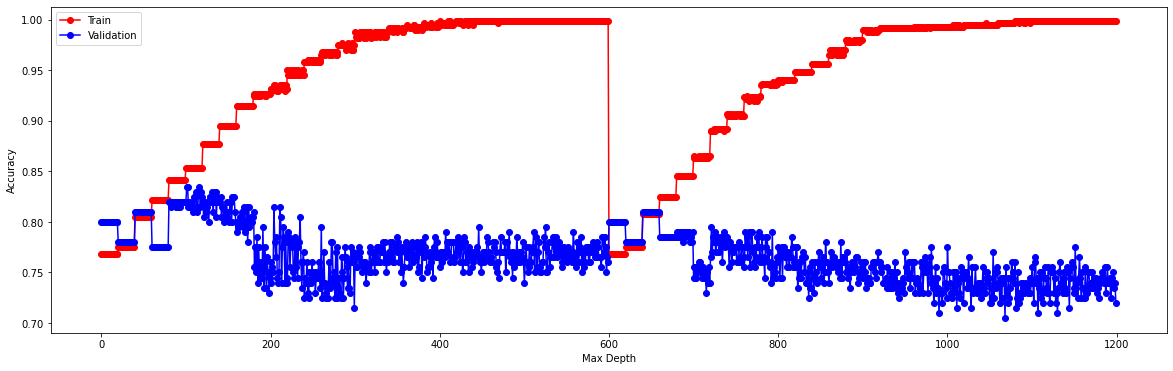

In [124]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
best_params = param_comb[np.argmax(val_acc)]
print('best params for Decision tree', best_params)

* Použijeme nejlepší kombinaci hyperparametrů, nacvičíme model a otestujeme přesnost předpovědi na trenovací a validační množině

In [125]:
tree = DecisionTreeClassifier(**best_params)
tree.fit(XtrainDT, ytrainDT)

print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrainDT, tree.predict(XtrainDT))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yvalDT, tree.predict(XvalDT))))


accuracy score (train): 0.846667
accuracy score (validation): 0.815000


1. Přesnost (trénovací data): 84.67%
    * Model dosáhl vysoké přesnosti 84.67% na datech, na kterých byl trénován. To naznačuje schopnost modelu dobře se naučit a přizpůsobit se trénovacím datům.
2. Přesnost (validační data): 81.5%
    * Na validační sadě dosáhl model přesnosti 81.5%. Tato hodnota je blízká výsledku na trénovací sadě, což naznačuje dobrou schopnost modelu generalizovat naučené vzory na nová data.

## kNN...
* Výhody tohoto modelu
    * Relativně malé dimenze: V našem datasetu je relativně málo atributů, což urychlí proces predikce
    * Jednoduchost: Jednoduchý a snadno pochopitelný, nepotřebuje složité předpoklady o datech
    * Flexibilita v manipulaci s daty: Pracuje s různými typy dat - numerickými i kategoriálními
    * Bez předpokladů o datech: Nepožaduje explicitní předpoklady o struktuře dat

* Zde provedeme stejné akce jako dříve
    * Data rozdělíme do tří částí: trénovací, validační a testovací v poměru 60/20/20 %
    * Vybereme hyperparametry
    * Pak každou kombinaci hyperparametrů vyzkoušíme na validační množině, abychom našli tu "nejlepší"
    * Použijeme nejlepší kombinaci hyperparametrů, nacvičíme model a otestujeme přesnost předpovědi na trenovací a validační množině 

In [126]:
XtrainKNN, XtestKNN, ytrainKNN, ytestKNN = train_test_split(kNN_Xdata, kNN_ydata, test_size=0.4, random_state=rd_seed)
XvalKNN, XtestKNN, yvalKNN, ytestKNN = train_test_split(XtestKNN, ytestKNN, test_size=0.5, random_state=rd_seed)

In [127]:
clf = KNeighborsClassifier()
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [128]:
kNN_param_grid = {
    "n_neighbors" : range(5, 50, 5),
    "metric" : ["euclidean", "manhattan"],
    "weights" : ["uniform", "distance"],
    "norm" : ["MinMax", "Standard", "No"]
}

kNN_param_comb = ParameterGrid(kNN_param_grid)
print("Number of combinations: {}".format(len(kNN_param_comb)))
print("\nThe first 10 combinations...")
for i in range(10):
    print(kNN_param_comb[i])

Number of combinations: 108

The first 10 combinations...
{'weights': 'uniform', 'norm': 'MinMax', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'distance', 'norm': 'MinMax', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'uniform', 'norm': 'Standard', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'distance', 'norm': 'Standard', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'uniform', 'norm': 'No', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'distance', 'norm': 'No', 'n_neighbors': 5, 'metric': 'euclidean'}
{'weights': 'uniform', 'norm': 'MinMax', 'n_neighbors': 10, 'metric': 'euclidean'}
{'weights': 'distance', 'norm': 'MinMax', 'n_neighbors': 10, 'metric': 'euclidean'}
{'weights': 'uniform', 'norm': 'Standard', 'n_neighbors': 10, 'metric': 'euclidean'}
{'weights': 'distance', 'norm': 'Standard', 'n_neighbors': 10, 'metric': 'euclidean'}


In [129]:
# Použijeme konkretní normalizaci
def to_norm(norm, x_train, x_val, x_test):
    scaler = None
    if norm == "MinMax": # MinMax normalizace
        scaler = MinMaxScaler()
    elif norm == "Standard": # Standartizace
        scaler = StandardScaler()

    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
    x_val_scaled = pd.DataFrame(scaler.transform(x_val), index=x_val.index, columns=x_val.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)
    
    return x_train_scaled, x_val_scaled, x_test_scaled


def knn(comb, Xtrain, Xval, ytrain, yval, kNN_train_acc, kNN_val_acc):
    kNN_model = KNeighborsClassifier(n_neighbors=comb["n_neighbors"], metric=comb["metric"], weights=comb["weights"])
    kNN_model.fit(Xtrain, ytrain)
    kNN_val_acc.append(kNN_model.score(Xval, yval))
    kNN_train_acc.append(kNN_model.score(Xtrain, ytrain))

In [130]:
kNN_val_acc = []
kNN_train_acc = []

for comb in kNN_param_comb:
    if comb["norm"] == "No":
        knn(comb, XtrainKNN, XvalKNN, ytrainKNN, yvalKNN, kNN_train_acc, kNN_val_acc)
    else:
        Xtrain_scaled, Xval_scaled, Xtest_scaled = to_norm(comb["norm"], XtrainKNN, XvalKNN, XtestKNN)
        knn(comb, Xtrain_scaled, Xval_scaled, ytrainKNN, yvalKNN, kNN_train_acc, kNN_val_acc)

Best params for kNN model:  {'weights': 'uniform', 'norm': 'Standard', 'n_neighbors': 15, 'metric': 'manhattan'}


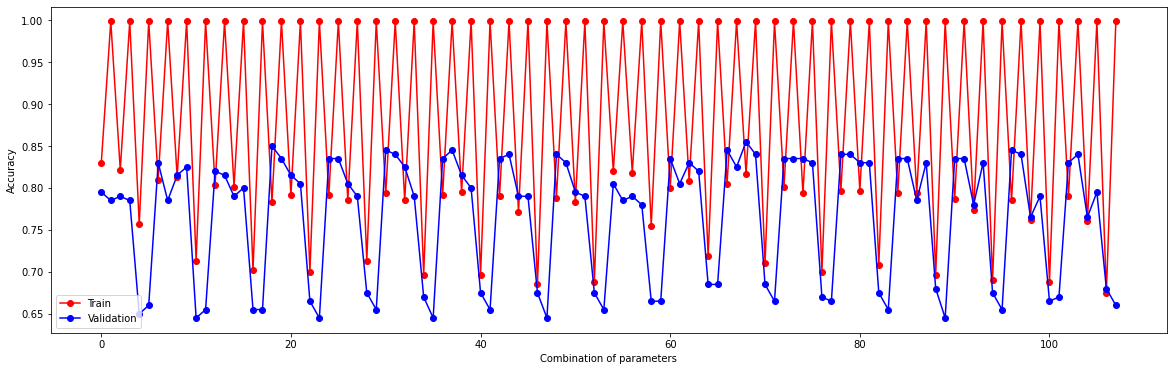

In [131]:
plt.figure(figsize=(20,6))
plt.plot(kNN_train_acc,'or-')
plt.plot(kNN_val_acc,'ob-')
plt.xlabel('Combination of parameters')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
best_kNN_params = kNN_param_comb[np.argmax(kNN_val_acc)]
print('Best params for kNN model: ', best_kNN_params)

In [132]:
Xtrain_scaled, Xval_scaled, Xtest_scaled = to_norm(best_kNN_params["norm"], XtrainKNN, XvalKNN, XtestKNN)

kNN_model = KNeighborsClassifier(n_neighbors=best_kNN_params["n_neighbors"], metric=best_kNN_params["metric"], weights=best_kNN_params["weights"])
kNN_model.fit(Xtrain_scaled, ytrainKNN)

print('accuracy score (train): {0:.6f}'.format(kNN_model.score(Xtrain_scaled, ytrainKNN)))
print('accuracy score (validation): {0:.6f}'.format(kNN_model.score(Xval_scaled, yvalKNN)))

accuracy score (train): 0.816667
accuracy score (validation): 0.855000


1. Přesnost (trénovací množina): 81.67%
    * Model dosáhl přesnosti 81.67% na datech, na kterých byl trénován. To znamená, že při použití stejných dat, na kterých se učil, byl schopen správně klasifikovat kolem 81.67% případů.
2. Přesnost (validační množina): 85.50%
    * Na validační množině model dosáhl přesnosti 85.50%. To naznačuje, že jeho schopnost generalizace na nová data je relativně dobrá a dosáhl ještě lepších výsledků než na trénovací množině.

## Výběr finálního model
   * Výběr finálního modelu je také volbou hyperparametru, takže jej bude správně vybírat na základě výsledků přesnosti na validační množině
   * Podle výsledků testování favoritem je kNN model (85.50% > 81.50%)

* Dalším krokem bude vypočítat očekávanou přesnost předpovědí našeho modelu na testovací sadě dat, kterou model neviděl při tréninku
* Také vypočítáme F1 skóre, nakresleme ROC křivku a určíme AUC

In [133]:
kNN_predictions = kNN_model.predict(Xtest_scaled)
kNN_pred_proba = kNN_model.predict_proba(Xtest_scaled)
pred_proba = kNN_pred_proba[:,1]

kNN_accuracy = metrics.accuracy_score(ytestKNN, kNN_predictions)
print('accuracy score (test): {0:.6f}'.format(kNN_accuracy))

kNN_f1 = f1_score(ytestKNN, kNN_predictions)
kNN_auc = roc_auc_score(ytestKNN, pred_proba)
print(f"F1 score: {kNN_f1}")
print(f"AUC: {kNN_auc}")

accuracy score (test): 0.790000
F1 score: 0.7341772151898734
AUC: 0.8083400974025974


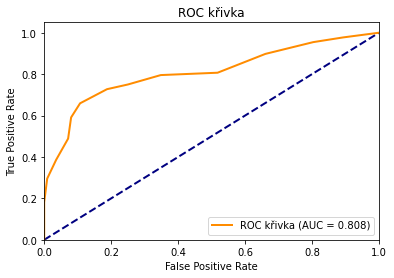

In [134]:
fpr, tpr, thresholds = roc_curve(ytestKNN, pred_proba)

# Vykreslení ROC křivky
plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {kNN_auc:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

1. Přesnost (testovací sada): 79.00%
    * Model dosáhl přesnosti 79.00% na testovací sadě. Tato hodnota znamená, že správně klasifikoval přibližně 79.00% testovacích vzorků
2. F1 skóre: 0.734
    * F1 skóre, které bere v úvahu jak precision, tak recall, je 0.734. Tato hodnota vyjadřuje vyváženou míru mezi přesností a úplností klasifikace
3. AUC (plocha pod ROC křivkou): 0.808
    * Plocha pod ROC křivkou je 0.808, což indikuje výkon modelu v rámci diskriminace mezi pozitivními a negativními třídami. Čím vyšší je hodnota AUC (plochy pod křivkou), tím lepší je schopnost modelu rozlišit mezi pozitivními a negativními třídami

Celkově řečeno, model K-NN dosáhl dobrých výsledků na testovací sadě, s přesností kolem 79.00%. F1 skóre a AUC také ukazují na slušný výkon modelu, což naznačuje schopnost klasifikovat a dobře rozlišit mezi třídami

* A konečně nacvičíme náš finální model na celém datasetu a předpovídáme osud cestujících z evaluation.csv
* Výsledky uložíme do results.csv

In [135]:
scale = StandardScaler()
Xdata_scaled = pd.DataFrame(scale.fit_transform(kNN_Xdata), index=kNN_Xdata.index, columns=kNN_Xdata.columns)
evaluation_scaled = pd.DataFrame(scale.transform(evaluation), index=evaluation.index, columns=evaluation.columns)

kNN_model = KNeighborsClassifier(n_neighbors=best_kNN_params["n_neighbors"], metric=best_kNN_params["metric"], weights=best_kNN_params["weights"])
kNN_model.fit(Xdata_scaled, kNN_ydata)

predict = kNN_model.predict(evaluation_scaled)
predict = predict.astype(int)

results = pd.DataFrame({'ID':evaluation.index, 'survived': predict})
results.to_csv('results.csv',index=False)

In [136]:
results.survived.value_counts()

survived
0    223
1     86
Name: count, dtype: int64